# Begin with baseline models

[Ryan Herr](https://rrherr.github.io/)

### About me

[My data science career](https://www.linkedin.com/in/ryan-herr-b5a8a77/) began at State Farm, a Fortune 50 insurance company. I started learning in 2012 and officially earned the title in 2015.

Out of 20 data scientists on their inaugural team, I was one of only two with just a Bachelor’s degree. I didn’t have the time, money, or geographic mobility for a “traditional” Master’s, but didn’t let that stop me from changing careers...

### My mentor's advice

It's amazing how much information is online, but it can be overwhelming to sift through. So I was fortunate to find a [mentor](https://www.linkedin.com/in/jason-sanchez-62093847/) to help point me in the right direction.

[He taught me](https://youtu.be/0GrciaGYzV0?t=40s):

> ***Your first goal should always, always, always be getting a generalized prediction as fast as possible.*** You shouldn't spend a lot of time trying to tune your model, trying to add features, trying to engineer features, until you've actually gotten one prediction, at least. 

> The reason why that's a really good thing is because then ***you'll set a benchmark*** for yourself, and you'll be able to directly see how much effort you put in translates to a better prediction. 

> What you'll find by working on many models: some effort you put in, actually has very little effect on how well your final model does at predicting new observations. Whereas some very easy changes actually have a lot of effect. And so you get better at allocating your time more effectively.

### From advice to examples

To apply this advice, it's helpful to see examples in code. My mentor made a [video](https://youtu.be/0GrciaGYzV0), but it's 3.5 years old and out-of-date. The advice is timeless, but code is not! Thankfully, today we can build baselines even faster. I teach an updated method in this notebook.

My mentor's advice is echoed and elaborated in several sources:

#### [Always start with a stupid model, no exceptions](https://blog.insightdatascience.com/always-start-with-a-stupid-model-no-exceptions-3a22314b9aaa)

> Why start with a baseline? A baseline will take you less than 1/10th of the time, and could provide up to 90% of the results. A baseline puts a more complex model into context. Baselines are easy to deploy.

#### [Measure Once, Cut Twice: Moving Towards Iteration in Data Science](https://blog.datarobot.com/measure-once-cut-twice-moving-towards-iteration-in-data-science)

> The iterative approach in data science starts with emphasizing the importance of getting to a first model quickly, rather than starting with the variables and features. Once the first model is built, the work then steadily focuses on continual improvement.

#### [*Data Science for Business*](https://www.safaribooksonline.com/library/view/data-science-for/9781449374273/), Chapter 7.3: Evaluation, Baseline Performance, and Implications for Investments in Data

> *Consider carefully what would be a reasonable baseline against which to compare model performance.* This is important for the data science team in order to understand whether they indeed are improving performance, and is equally important for demonstrating to stakeholders that mining the data has added value.

Throughout this notebook, I will take excerpts from these sources. However, they don't contain any code — so I will add examples to demonstrate the advice in action.

## Before we get started

This lesson assumes you've learned these **pre-requisites**:
- Jupyter, matplotlib, pandas: experience equivalent to [Reproducible Data Analysis in Jupyter](http://jakevdp.github.io/blog/2017/03/03/reproducible-data-analysis-in-jupyter/), Parts 1 & 2
- scikit-learn: experience equivalent to [Introduction to machine learning in Python with scikit-learn](https://www.dataschool.io/machine-learning-with-scikit-learn/)

Also, you'll need to install these **dependencies**:
- [Anaconda Distribution, Python 3 version](https://www.anaconda.com/download/)
- `conda install -c conda-forge category_encoders` for [Category Encoders](https://github.com/scikit-learn-contrib/categorical-encoding) 
- `conda install python-graphviz` to visualize [sklearn decision trees](http://scikit-learn.org/stable/modules/tree.html) in Jupyter

In [1]:
%matplotlib inline
from category_encoders import OneHotEncoder
import graphviz
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## Majority Classifier

*Data Science for Business* recommends,

> For classification tasks, one good baseline is the ***majority classifier, a naive classifier that always chooses the majority class of the training dataset.*** ... 

> This may seem like advice so obvious it can be passed over quickly, but it is worth spending an extra moment here. There are many cases where smart, analytical people have been tripped up in skipping over this basic comparison. For example, an analyst may see a classification accuracy of 94% from her classifier and conclude that it is doing fairly well—when in fact only 6% of the instances are positive. So, the simple majority prediction classifier also would have an accuracy of 94%.

#### Let's try it with the **[Titanic dataset](https://www.kaggle.com/c/titanic/data)** ... 

The target to predict is whether passengers survived. The majority class is `0`, meaning that a majority (61.6%) of passengers did not survive.

In [2]:
df = pd.read_csv('titanic/train.csv', index_col='PassengerId')
df.Survived.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

So if we just predict that every passenger did not survive, we get an accuracy of 61.6%.

In [3]:
predicted = [0] * len(df)  # List filled with zeros, the same length as the dataframe
accuracy_score(df.Survived, predicted)

0.61616161616161613

You can do the same thing in scikit-learn with ["dummy estimators"](http://scikit-learn.org/stable/modules/model_evaluation.html#dummy-estimators). This code may seem like overkill now, but we'll build on it for the following examples.

In [4]:
target = 'Survived'
scoring = 'accuracy'

X = df.drop(columns=[target]).select_dtypes(np.number)
y = df[target]

pipeline = make_pipeline(
    Imputer(), 
    DummyClassifier(strategy='most_frequent'))

cross_val_score(pipeline, X, y, scoring=scoring)

array([ 0.61616162,  0.61616162,  0.61616162])

## Decision stump, with only the numeric features

Next, *Data Science for Business* suggests ["decision stumps."](https://en.wikipedia.org/wiki/Decision_stump)

> A slightly more complex alternative is a model that only considers a very small amount of feature information. ...

> One example is to build a "decision stump"—a decision tree with only one internal node, the root node. A tree limited to one internal node simply means that the tree induction selects the single most informative feature to make a decision. In a well-known paper in machine learning, [Robert Holte (1993)](https://link.springer.com/article/10.1023/A:1022631118932) showed that ***decision stumps often produce quite good baseline performance*** ...

> A decision stump is an example of the strategy of ***choosing the single most informative piece of information*** available and basing all decisions on it. In some cases most of the leverage may be coming from a single feature, and this method assesses whether and to what extent this is the case.

We can do this, just changing one line of code, to use a [`DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) model with parameter `max_depth=1`.

In the previous code cell, we selected only the numeric features, to avoid data wrangling and save time. For now, we'll continue to use only the numeric features.

The cross-validated score has some variance but its average is higher than the majority classifier:

In [5]:
pipeline = make_pipeline(
    Imputer(), 
    DecisionTreeClassifier(max_depth=1))

cross_val_score(pipeline, X, y, scoring=scoring)

array([ 0.60942761,  0.66666667,  0.7037037 ])

We can visualize the decision stump to see which numeric feature was "the single most informative": `Pclass` (Passenger Class).

The model predicts:
- 1st & 2nd class passengers survive, because the majority (55.8%) did.
- 3rd class passengers did *not* survive, because the majority (75.8%) did not.

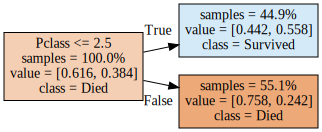

In [6]:
pipeline.fit(X, y)
model = pipeline.named_steps['decisiontreeclassifier']
feature_names = X.columns
class_names = ['Died', 'Survived']

dot_data = export_graphviz(model, out_file=None, feature_names=feature_names, class_names=class_names, 
                           filled=True, impurity=False, proportion=True, rotate=True)

graphviz.Source(dot_data)

You can think of this like a pivot table, and the decision stump automatically found the best numeric feature to "pivot on" that separates the classes.

In [7]:
df.pivot_table('Survived', df.Pclass <= 2.5)

,Survived
Pclass,
False,0.242363
True,0.557500


## Decision stump, with more features

However, if we consider non-numeric features, there's an even better feature to pivot on:

In [8]:
df.pivot_table('Survived', 'Sex')

,Survived
Sex,
female,0.742038
male,0.188908


So, we'll add more features. 

First, let's look at what non-numeric features we have, and how many unique values each has.

In [9]:
df.select_dtypes(exclude=np.number).nunique()

Name        891
Sex           2
Ticket      681
Cabin       147
Embarked      3
dtype: int64

We can use [one-hot encoding](http://contrib.scikit-learn.org/categorical-encoding/onehot.html) for categoricals with low [cardinality](https://simple.wikipedia.org/wiki/Cardinality), like `Sex` and `Embarked`. 

But we probably don't want to use one-hot-encoding with the other, higher cardinality features, because it would add too many dimensions to our dataset. So we will automatically exclude features with high cardinality.

In [10]:
max_cardinality = 50  # Semi-arbitrary limit

high_cardinality = [col for col in df.select_dtypes(exclude=np.number)
                    if df[col].nunique() > max_cardinality]

X = df.drop(columns=[target] + high_cardinality)
y = df[target]

Then we add the `OneHotEncoder` to our pipeline with just one line of code, and run it. The cross-validated accuracy score increased, to ~ 79%.

In [11]:
pipeline = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    Imputer(), 
    DecisionTreeClassifier(max_depth=1))

cross_val_score(pipeline, X, y, scoring=scoring)

array([ 0.78787879,  0.8013468 ,  0.77104377])

As expected, we see the decision stump now finds `Sex` to be the the single most informative feature:

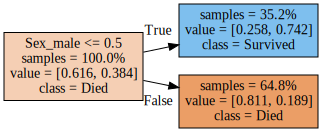

In [12]:
pipeline.fit(X, y)
model = pipeline.named_steps['decisiontreeclassifier']
feature_names = pipeline.named_steps['onehotencoder'].transform(X).columns
class_names = ['Died', 'Survived']

dot_data = export_graphviz(model, out_file=None, feature_names=feature_names, class_names=class_names, 
                           filled=True, impurity=False, proportion=True, rotate=True)

graphviz.Source(dot_data)

## Decision tree, with a bit more depth

We can grow our tree beyond a stump, giving it a bit more depth, by changing the `max_depth` parameter. 

Here's the same code re-run, but with `max_depth=3`.

In [13]:
pipeline = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    Imputer(), 
    DecisionTreeClassifier(max_depth=3))

cross_val_score(pipeline, X, y, scoring=scoring)

array([ 0.7979798 ,  0.81818182,  0.81144781])

The cross-validated accuracy score increased, to ~ 80%. This is baseline score that more sophisticated models must beat. 

Is more effort justified? It depends. The blogpost ["Always start with a stupid model"](https://blog.insightdatascience.com/always-start-with-a-stupid-model-no-exceptions-3a22314b9aaa) explains,

> Here is a very common story: a team wants to implement a model to predict something like the probability of a user clicking an ad. They start with a logistic regression and quickly (after some minor tuning) reach 90% accuracy.

> From there, the question is: Should the team focus on getting the accuracy up to 95%, or should they solve other problems 90% of the way?

> ***If a baseline does well, then you’ve saved yourself the headache of setting up a more complex model. If it does poorly, the kind of mistakes it makes are very instructive*** ...

So what else can we learn from this baseline? We can visualize the tree like before, although it's getting unwieldy and hard to interpret:

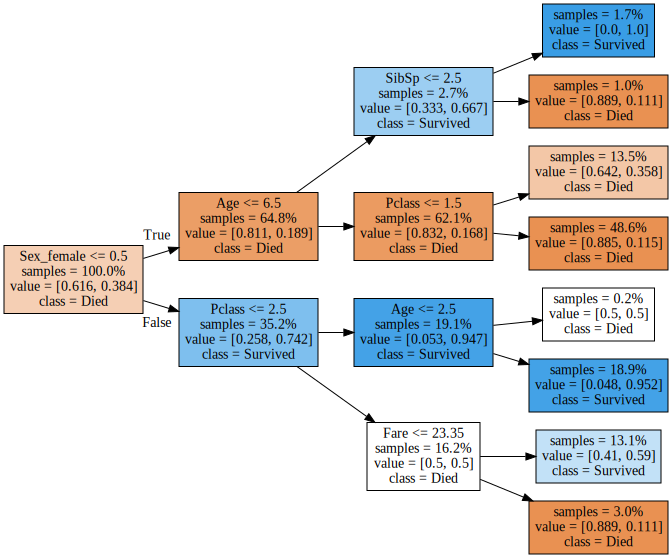

In [14]:
pipeline.fit(X, y)
model = pipeline.named_steps['decisiontreeclassifier']
feature_names = pipeline.named_steps['onehotencoder'].transform(X).columns
class_names = ['Died', 'Survived']

dot_data = export_graphviz(model, out_file=None, feature_names=feature_names, class_names=class_names, 
                           filled=True, impurity=False, proportion=True, rotate=True)

graphviz.Source(dot_data)

["Always start with a stupid model"](https://blog.insightdatascience.com/always-start-with-a-stupid-model-no-exceptions-3a22314b9aaa) suggests to look at

> **What type of signal your model picks up on.** Most baselines will allow you to extract ***feature importances***, revealing which aspects of the input are most predictive. Analyzing feature importance is a great way to realize how your model is making decisions, and what it might be missing.

We can do that:

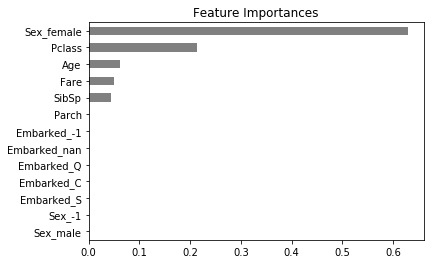

In [15]:
pd.Series(model.feature_importances_, feature_names).sort_values().plot.barh(color='gray')
plt.title('Feature Importances');

Also, 

> **Which classes are harder to separate.** For most classification problems, looking at a ***confusion matrix*** will be very informative in learning which classes are giving your model trouble.

But sklearn's confusion matrix is hard to read, because it doesn't have labels ...

In [16]:
y_pred = cross_val_predict(pipeline, X, y)
confusion_matrix(y, y_pred)

array([[496,  53],
       [117, 225]], dtype=int64)

So I wrote this wrapper function:

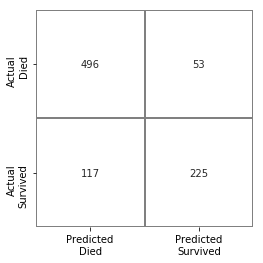

In [17]:
def confusion_matrix_viz(y_true, y_pred, classes=None):
    matrix = confusion_matrix(y_true, y_pred)
    if not classes: classes = np.unique(y_true)
    xticklabels = ['Predicted' + '\n' + str(c) for c in classes]
    yticklabels = ['Actual' + '\n' + str(c) for c in classes]
    cmap = ListedColormap(['white'])
    return sns.heatmap(matrix, cmap=cmap, cbar=False, annot=True, fmt=',', 
                       linewidths=1, linecolor='grey', square=True, 
                       xticklabels=xticklabels, yticklabels=yticklabels)

confusion_matrix_viz(y, y_pred, classes=['Died', 'Survived']);

We see more "Predicted Died / Actual Survived" errors than "Predicted Survived / Actual Died" errors.

This could lead us to consider, 

> **What signal your model is missing.** If there is a certain aspect of the data that seems intuitively important but that your model is ignoring, ***a good next step is to engineer a feature*** or pick a different model that could better leverage this particular aspect of your data.

## BONUS: Logistic Regression

We've been using decision trees, but ["Always start with a stupid model"](https://blog.insightdatascience.com/always-start-with-a-stupid-model-no-exceptions-3a22314b9aaa) also recommends Logistic Regression for classification baselines. 

We can fit a Logistic Regression model, with minor code modifications:
- I suggest adding `StandardScaler` preprocessing to the pipeline. 
- Also, Logistic Regression doesn't have the `.feature_importances_` attribute, instead it has `.coef_`.

Cross-validation scores: [ 0.78787879  0.78114478  0.7979798 ]


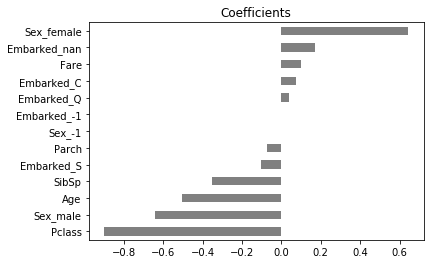

In [18]:
pipeline = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    Imputer(), 
    StandardScaler(), 
    LogisticRegression())

scores = cross_val_score(pipeline, X, y, scoring=scoring)
print('Cross-validation scores:', scores)

pipeline.fit(X, y)
model = pipeline.named_steps['logisticregression']
feature_names = pipeline.named_steps['onehotencoder'].transform(X).columns
coefficients = pd.Series(model.coef_[0], feature_names)
coefficients.sort_values().plot.barh(color='gray')
plt.title('Coefficients');

## Regression

We began with the majority classifier. What about regression?

*Data Science for Business* suggests,

> For regression problems we have a directly analogous baseline: predict the average value over the population (usually the mean or median).

#### Let's try it with Weather data...

You can [get Past Weather by Zip Code from Climate.gov](https://www.climate.gov/maps-data/dataset/past-weather-zip-code-data-table). I downloaded the data for my town: Normal, Illinois.

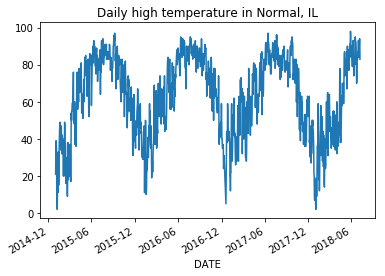

In [19]:
weather = pd.read_csv('weather/weather-normal-il.csv', parse_dates=['DATE'])
weather.set_index('DATE', inplace=True)
weather['2015':'2018'].TMAX.plot()
plt.title('Daily high temperature in Normal, IL');

Over the years, across the seasons, the average daily high temperature in my town is about 63 degrees.

In [20]:
weather.TMAX.mean()

62.562754852389496

If I predicted that every day, the high will be 63 degrees, I'd be off by about 19 degrees on average.

In [21]:
predicted = [weather.TMAX.mean()] * len(weather)  
mean_absolute_error(weather.TMAX, predicted)

18.684890040509288

But, with time series data like this, we can get a better baseline.

*Data Science for Business* explains, 

> Weather forecasters have two simple—but not simplistic—baseline models that they compare against. ***One (persistence) predicts that the weather tomorrow is going to be whatever it was today.*** The other (climatology) predicts whatever the average historical weather has been on this day from prior years. Each model performs considerably better than random guessing, and both are so easy to compute that they make natural baselines of comparison. Any new, more complex model must beat these.

Let's predict that the weather tomorrow is going to be whatever it was today. Which is another way of saying that the weather today is going to be whatever it was yesterday.

We can engineer this function with one line of code, using the pandas [`shift`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shift.html) function.

This new baseline is off by less than 6 degress on average.

In [22]:
weather['TMAX_yesterday'] = weather.TMAX.shift(1)
weather.dropna(inplace=True)  # Drops the first date from the dataset, because it doesn't have a "yesterday"
mean_absolute_error(weather.TMAX, weather.TMAX_yesterday)

5.5195938506707991

I applied this same concept for [my first submission to the Kaggle Instacart competition.](https://github.com/rrherr/springboard/blob/master/Kaggle%20Instacart%20first%20submission.ipynb)


# Next Steps

### Look at your data (you still need to do it!)

Cautionary tales
- [Exploring the ChestXray14 dataset: problems](https://lukeoakdenrayner.wordpress.com/2017/12/18/the-chestxray14-dataset-problems/)
- [The Quartz guide to bad data](https://github.com/Quartz/bad-data-guide)

Incomplete list of issues to address
- Categoricals (text, dates/times, high cardinality)
- Feature Engineering (extraction, interaction, transformations)
- Missing Values
- Outliers

### Choose your classifier's metric
- [*Data Science for Business*](https://www.safaribooksonline.com/library/view/data-science-for/9781449374273/), Chapter 7.2, A Key Analytical Framework: Expected Value
- [Learning from Imbalanced Classes](https://www.svds.com/tbt-learning-imbalanced-classes/)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)
- [The philosophical argument for using ROC curves](https://lukeoakdenrayner.wordpress.com/2018/01/07/the-philosophical-argument-for-using-roc-curves/)
- [Using a confusion matrix with a cost benefit matrix to solve for expected value](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)

### Choose your classifier's threshold
- [*Data Science for Business*](https://www.safaribooksonline.com/library/view/data-science-for/9781449374273/), Chapter 8, Visualizing Model Performance
- [Counterfactual evaluation of machine learning models](https://www.youtube.com/watch?v=QWCSxAKR-h0)
- [Machine Learning Meets Economics, Part 1](http://blog.mldb.ai/blog/posts/2016/01/ml-meets-economics/) & [Part 2](http://blog.mldb.ai/blog/posts/2016/04/ml-meets-economics2/)
- [Sales Analytics: How to Use Machine Learning to Predict and Optimize Product Backorders](http://www.business-science.io/business/2017/10/16/sales_backorder_prediction.html)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)